<a href="https://colab.research.google.com/github/PerlaMolina/BMI212-AURA/blob/main/FC_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

autoencoder to extract / do feature selection on Functional Connectome Data

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# load data
from google.colab import drive
import pandas as pd
drive.mount('/content/drive/')
file_path = '/content/drive/My Drive/widsdata/'


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import pickle
import os
from random import seed
import matplotlib.pyplot as plt
behavorial_data = pd.read_excel(file_path+'TRAIN_QUANTITATIVE_METADATA_new.xlsx')
label_data = pd.read_excel(file_path+'TRAINING_SOLUTIONS.xlsx')
FC_data = pd.read_csv(file_path+ 'TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')

seed(0)
all_data_with_label = pd.merge(behavorial_data, label_data, how= 'left', on= ['participant_id'])
all_data_with_label = pd.merge(all_data_with_label, FC_data, how= 'left', on= ['participant_id'])
all_data_with_label['stratify'] = all_data_with_label['Sex_F'].astype(str) + '_' + all_data_with_label['ADHD_Outcome'].astype(str)

# drop NAN
all_data_with_label = all_data_with_label.dropna()

# drop columns not related to ADHD: "EHQ_EHQ_Total" - Laterality Index (Score), "ColorVision_CV_Score" - Color vision test score
all_data_with_label = all_data_with_label.drop(columns=['EHQ_EHQ_Total', 'ColorVision_CV_Score'])


Custom Dataset Clas

In [ ]:
from torch.utils.data import Dataset, DataLoader

class LoadWidsDataset(Dataset):
    def __init__(self, train_df, label_column, transform=None):

      train_df_copy = train_df.copy().reset_index(drop=True)
      self.dataframe = train_df_copy
      self.transform = transform
      self.features = train_df_copy.drop(columns=[label_column])
      self.labels = train_df_copy[label_column]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):

        feature = torch.tensor(self.features.iloc[idx].values, dtype=torch.float32)

        label = torch.tensor(self.labels.iloc[idx], dtype=torch.float32)
        return feature, label



autoencoder

autoencoder structure references: https://www.cs.toronto.edu/~lczhang/360/lec/w05/autoencoder.html#Transpose-Convolutions-and-Autoencoders

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

class FC_Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()      ### init the super class

        latent_dim = [8000, 3000, 1000, 500, 100, 50] # arbitrary chosen (in general *0.5 or less of the previous layer)

        encoder_layers = []
        prev_dim = 19900

        for dim in latent_dim:
            encoder_layers.extend([
                nn.Linear(prev_dim, dim),
                nn.BatchNorm1d(dim),
                nn.ReLU(),
                nn.Dropout(0.3) # tried 0.3 for dropout rate bc total data = 812, which is small, need to prevent overfit
            ])
            prev_dim = dim

        encoder_layers = encoder_layers[:-2]  # use linear features for classification
        self.encoder = nn.Sequential(*encoder_layers)


        decoder_layers = []
        reversed_dims = list(reversed(latent_dim[:-1])) + [19900]
        prev_dim = latent_dim[-1]

        for i, dim in enumerate(reversed_dims):
            decoder_layers.extend([
                nn.Linear(prev_dim, dim),
                nn.BatchNorm1d(dim) if i < len(reversed_dims) - 1 else nn.Identity(),
                nn.ReLU() if i < len(reversed_dims) - 1 else nn.Tanh(),
                nn.Dropout(0.3) if i < len(reversed_dims) - 1 else nn.Identity()
            ])
            # the last layer is outputed by Tanh, which gives values between -1 to 1, which is the same as the FC input
            prev_dim = dim

        self.decoder = nn.Sequential(*decoder_layers)


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
      return self.encoder(x)


In [ ]:
FC_columns_names = [x for x in FC_data.columns if 'row' in x and 'column' in x and 'th' in x]

# all
FC_all_subjects_train = all_data_with_label.drop(columns=['participant_id', 'Sex_F', 'stratify'])
FC_all_subjects_train = FC_all_subjects_train[FC_columns_names + ['ADHD_Outcome']]

# data loader
all_subject_loader = DataLoader(LoadWidsDataset(FC_all_subjects_train,label_column = 'ADHD_Outcome' ),
                                             batch_size= 50, shuffle=True)


# training
model = FC_Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

train_losses = []
num_epochs = 1000

for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0
    num_batches = 0

    for FC_data_i, _ in all_subject_loader :
        FC_data_i = FC_data_i.to(device)

        reconstruction = model(FC_data_i)
        loss = criterion(reconstruction, FC_data_i)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # update weights

        train_loss += loss.item()
        num_batches += 1


    train_losses.append(train_loss / num_batches)


Text(0.5, 1.0, 'MSE loss over 1000 epochs')

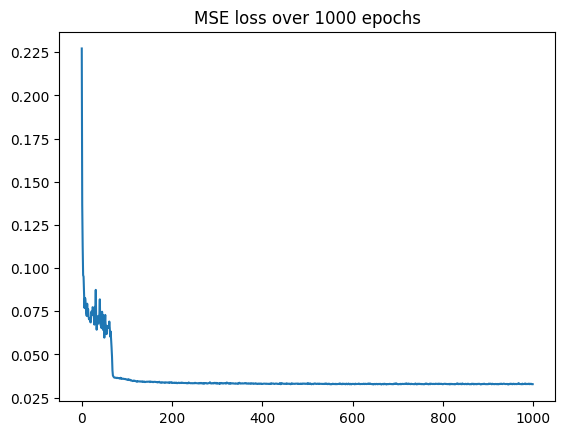

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(train_losses)
plt.title('MSE loss over 1000 epochs')

In [ ]:
torch.save(model, file_path+'autoencoder/FC_autoencoder')
torch.save(model.state_dict(), file_path+'autoencoder/FC_autoencoder_stateDict')

feature extraction

In [ ]:
model.eval()
all_subject_with_id_df = all_data_with_label.drop(columns=['Sex_F', 'stratify', 'ADHD_Outcome']) [FC_columns_names + ['participant_id']]

all_subject_with_id = all_subject_with_id_df.reset_index(drop=True, inplace=True)

output = []
for idx, _ in all_subject_with_id_df.iterrows():
  df_i = all_subject_with_id_df.iloc[idx]
  ID_i = df_i['participant_id']
  FC_data_i = torch.tensor(all_subject_with_id_df[FC_columns_names].iloc[idx].values, dtype = torch.float32)
  with torch.no_grad():
    FC_data_i = FC_data_i.unsqueeze(0).to(device)
    encoded_i = model.encode(FC_data_i)
    encoded_i = encoded_i.cpu().numpy().squeeze(0)

  output.append([ID_i] + encoded_i.tolist())




In [ ]:
FC_extracted_names = ['extracted_FC_'+ str(i) for i in range(50)]
FC_extracted = pd.DataFrame(output, columns=['participant_id'] + FC_extracted_names)
FC_extracted.to_csv(file_path+'autoencoder/FC_extracted.csv')

feature extraction function for future use

In [ ]:
def feature_extraction_AC(path_to_model, data_df):
  model_feature = FC_Autoencoder()
  model_feature.load_state_dict(torch.load(path_to_model))
  model_feature.eval()
  model_feature.to(device)

  output = []
  for idx, _ in data_df.iterrows():
    df_i = data_df.iloc[idx]
    ID_i = df_i['participant_id']
    FC_data_i = torch.tensor(data_df[FC_columns_names].iloc[idx].values, dtype = torch.float32)
    with torch.no_grad():
      FC_data_i = FC_data_i.unsqueeze(0).to(device)
      encoded_i = model_feature.encode(FC_data_i)
      encoded_i = encoded_i.cpu().numpy().squeeze(0)

    output.append([ID_i] + encoded_i.tolist())

  return output